# Train model

Train and fine-tune a headless MobileNet V3 on a target image dataset directory

## Config

In [1]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomZoom, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
import os
from pathlib import Path
import logging
import pandas as pd
import numpy as np
import sqlalchemy as sqa
from typing import Callable

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.propagate = False

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 12

# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [2]:
# PARAMETERS
# Model Parameters
image_size = (224, 224)
batch_size = 16
dropout_rate = 0.2
shuffle_buffer = 50

epochs = {
    'top_layer': 500,
    'fine_tuning': 500
}

learning_rates = {
    'top_layer': 0.0001,
    'fine_tuning': 0.00001
}

fine_tune_unfreeze_frac = 0.3


# Data parameters
db_container = "metadata_db"
db_user = "pguser"
db_password = "pgpassword"
db_port = 5432
db_database = "metadata"
db_prefix = "postgresql"

class_weights = {} # TODO use class weights

metadata_tbl = "base_images"
datasets_tbl = "datasets"
dataset_img_tbl = "dataset_images"

dataset_name = "all_v1_multiclass"

In [3]:
db_con_str = f"{db_prefix}://{db_user}:{db_password}@{db_container}:{db_port}/{db_database}"
db_engine = sqa.create_engine(db_con_str)

input_shape = (*image_size, 3)

In [4]:
with db_engine.connect() as con:
    df_dataset = pd.read_sql_query(f"""
                                   SELECT * FROM {datasets_tbl}
                                   WHERE name = '{dataset_name}'
                                   """, con, index_col='name')
    df_imgs = pd.read_sql_query(f"""
                                SELECT * FROM {dataset_img_tbl}
                                LEFT JOIN {metadata_tbl} ON {dataset_img_tbl}.image_name = {metadata_tbl}.image_name
                                WHERE dataset_name = '{dataset_name}'
                                """
                                , con, index_col='image_name')
    
ds_config = df_dataset.loc[dataset_name].to_dict()
ds_config['has_test'] = ds_config['test_frac'] > 0
ds_config['has_val'] = ds_config['validation_frac'] > 0
ds_config

{'target_dir': '/home/code/datasets/pipeline_v1/all_v1_multiclass',
 'description': 'All images in v1 dataset with multiclass labels',
 'validation_frac': 0.2,
 'test_frac': 0.0,
 'label_method': 'MULTI',
 'has_test': False,
 'has_val': True}

In [5]:
train_dir = os.path.join(ds_config['target_dir'], 'train')
test_dir = os.path.join(ds_config['target_dir'], 'test')
val_dir = os.path.join(ds_config['target_dir'], 'validation')

## Datasets

In [6]:
def _get_image_name(img_path: str):
    """
    Convert image path to appropriate label
    """
    return(Path(img_path).name.replace("'", ""))

def label_tf_image_dataset(img_ds: tf.data.Dataset,
                           label_func: Callable[[str], str] = _get_image_name,
                           batch_size: int = batch_size) -> tf.data.Dataset:
    """
    Zips an image dataset (images, class_labels) with their image file names
    Works on unshuffled datasets & batch sizes must match
    Returns a dataset like ((images, class_labels), image_names)
    """
    img_labels = [label_func(img_path) for img_path in img_ds.file_paths]
    return tf.data.Dataset.zip((
        img_ds,
        tf.data.Dataset.from_tensor_slices(img_labels).batch(batch_size)
    ))
AUTOTUNE = tf.data.AUTOTUNE


# Make datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=image_size,
                                                            label_mode='categorical')
class_names = train_dataset.class_names
ds_labelled = {'train': label_tf_image_dataset(train_dataset)}
# train_dataset = train_dataset.shuffle(buffer_size=shuffle_buffer).prefetch(buffer_size=AUTOTUNE)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

val_dataset = None
if ds_config['has_val']:
    val_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                              batch_size=batch_size,
                                                              shuffle=True,
                                                              image_size=image_size,
                                                              label_mode='categorical')
    ds_labelled['val'] = label_tf_image_dataset(val_dataset)
    val_dataset = val_dataset.shuffle(buffer_size=shuffle_buffer)

test_dataset = None
if ds_config['has_test']:
    test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                              batch_size=batch_size,
                                                              shuffle=True,
                                                              image_size=image_size,
                                                              label_mode='categorical')
    ds_labelled['test'] = label_tf_image_dataset(test_dataset)
    test_dataset = test_dataset.shuffle(buffer_size=shuffle_buffer)

Found 8146 files belonging to 4 classes.
Found 2037 files belonging to 4 classes.


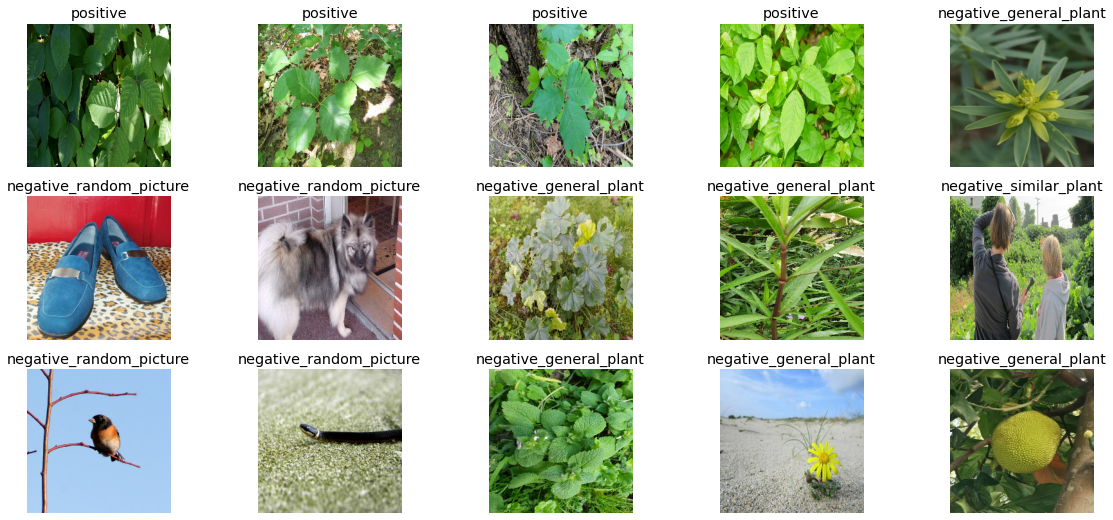

In [7]:
# TODO: fix so this takes from many class label?
n_classes = len(class_names)
y_ims = 3
x_ims = 5

plt.figure(figsize=(x_ims*4, y_ims*3))
for images, labels in train_dataset.take(1):
  for i in range(y_ims*x_ims):
    ax = plt.subplot(y_ims, x_ims, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i].numpy().argmax()])
    plt.axis("off")

## Processing layers

In [8]:

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)


### Image augmentation

In [9]:
image_aug = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomZoom(0.1)
])

### Mobilenet

In [10]:
mobilenet_large = MobileNetV3Large(input_shape=input_shape,
                                   include_top=False,
                                   weights='imagenet',
                                   pooling='avg',
                                   include_preprocessing=True,
                                   dropout_rate=dropout_rate)

mobilenet_large.trainable = False
mobilenet_large.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [11]:
def build_model(mobilenet):
    inputs = Input(shape=input_shape)
    x = image_aug(inputs)
    x = mobilenet(x, training=False)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(n_classes, activation='softmax')(x)
    
    return(Model(inputs, outputs))
    

In [12]:
model = build_model(mobilenet_large)

In [13]:
model.compile(optimizer=Adam(learning_rate=learning_rates['top_layer']),
              loss=CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [14]:
early_stopping = EarlyStopping(patience=12, restore_best_weights=False)
reduce_lr = ReduceLROnPlateau(patience=4, factor=1./3.)
callbacks = [early_stopping, reduce_lr]

In [15]:
kwargs = {
    'epochs': epochs['top_layer'],
    'callbacks': callbacks
}
if ds_config['has_val']:
    kwargs['validation_data'] = val_dataset

history = model.fit(train_dataset, **kwargs)
print("MODEL COMPLETE")

Epoch 1/500
510/510 [==============================] - 30s 49ms/step - loss: 0.5192 - accuracy: 0.8141 - val_loss: 0.3325 - val_accuracy: 0.8915
Epoch 2/500
510/510 [==============================] - 25s 48ms/step - loss: 0.2880 - accuracy: 0.8988 - val_loss: 0.2735 - val_accuracy: 0.8949
Epoch 3/500
510/510 [==============================] - 25s 49ms/step - loss: 0.2292 - accuracy: 0.9245 - val_loss: 0.2237 - val_accuracy: 0.9200
Epoch 4/500
510/510 [==============================] - 26s 51ms/step - loss: 0.1945 - accuracy: 0.9309 - val_loss: 0.1993 - val_accuracy: 0.9303
Epoch 5/500
510/510 [==============================] - 41s 81ms/step - loss: 0.1682 - accuracy: 0.9446 - val_loss: 0.1924 - val_accuracy: 0.9342
Epoch 6/500
510/510 [==============================] - 31s 60ms/step - loss: 0.1538 - accuracy: 0.9478 - val_loss: 0.1870 - val_accuracy: 0.9308
Epoch 7/500
510/510 [==============================] - 27s 52ms/step - loss: 0.1418 - accuracy: 0.9551 - val_loss: 0.1787 - val_ac

## Fine-tune models

In [16]:
unfreeze = int(len(mobilenet_large.layers) * fine_tune_unfreeze_frac)

print(f"Mobilenet-large: Unfreezing {unfreeze} of {len(mobilenet_large.layers)} layers")
mobilenet_large.trainable = True
for layer in mobilenet_large.layers[:-unfreeze]:
    layer.trainable = False

Mobilenet-large: Unfreezing 81 of 270 layers


In [17]:
mobilenet_large.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [18]:
model.compile(optimizer=RMSprop(learning_rate=learning_rates['fine_tuning']),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

In [19]:
print(len(history.epoch))

22


In [20]:
base_epochs = len(history.epoch)
history_FT = model.fit(train_dataset,
                       validation_data=val_dataset,
                       epochs=epochs['fine_tuning'] + base_epochs,
                       initial_epoch=history.epoch[-1],
                       callbacks=callbacks,
                       verbose=2)

Epoch 22/522
510/510 - 40s - loss: 0.0597 - accuracy: 0.9840 - val_loss: 0.1410 - val_accuracy: 0.9524
Epoch 23/522
510/510 - 36s - loss: 0.0576 - accuracy: 0.9848 - val_loss: 0.1484 - val_accuracy: 0.9524
Epoch 24/522
510/510 - 36s - loss: 0.0554 - accuracy: 0.9828 - val_loss: 0.1394 - val_accuracy: 0.9509
Epoch 25/522
510/510 - 44s - loss: 0.0533 - accuracy: 0.9863 - val_loss: 0.1409 - val_accuracy: 0.9543
Epoch 26/522
510/510 - 43s - loss: 0.0541 - accuracy: 0.9848 - val_loss: 0.1435 - val_accuracy: 0.9548
Epoch 27/522
510/510 - 43s - loss: 0.0486 - accuracy: 0.9870 - val_loss: 0.1329 - val_accuracy: 0.9553
Epoch 28/522
510/510 - 42s - loss: 0.0513 - accuracy: 0.9865 - val_loss: 0.1352 - val_accuracy: 0.9539
Epoch 29/522
510/510 - 41s - loss: 0.0511 - accuracy: 0.9866 - val_loss: 0.1446 - val_accuracy: 0.9548
Epoch 30/522
510/510 - 44s - loss: 0.0462 - accuracy: 0.9877 - val_loss: 0.1323 - val_accuracy: 0.9548
Epoch 31/522
510/510 - 43s - loss: 0.0492 - accuracy: 0.9864 - val_loss: 

## Analyze history

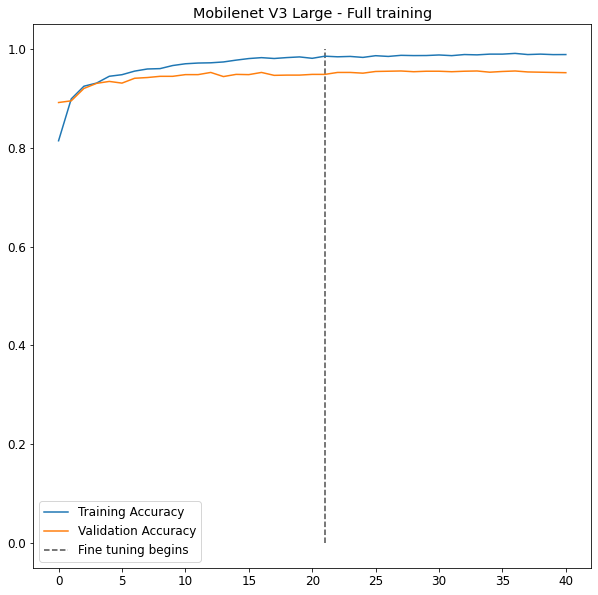

In [21]:
plt.figure(figsize=(10,10))

total_history = {}
for metric in ['accuracy', 'val_accuracy']:
    total_history[metric] = history.history[metric] + history_FT.history[metric]

ax = plt.subplot(1,1,1)
plt.plot(total_history['accuracy'], label='Training Accuracy')
plt.plot(total_history['val_accuracy'], label='Validation Accuracy')
y_min, y_max = (0, 1)
plt.vlines(base_epochs-1, ymin=y_min, ymax=y_max, label='Fine tuning begins', linestyles='--', colors=[0.3]*3)
plt.title("Mobilenet V3 Large - Full training")
plt.legend()


plt.show()

## Analyze results

In [22]:
POSITIVE = 'positive'
POSITIVE_IND = class_names.index(POSITIVE)

In [23]:
result_records = []
for split, dataset in ds_labelled.items():
    for ((imgs, class_labels), img_names) in dataset:
        probs = model.predict(imgs)
        class_values = class_labels.numpy().argmax(axis=1)
        for prob, class_val, img_name_bytes in zip(probs, class_values, img_names.numpy()):
            img_name = img_name_bytes.decode('utf-8')
            pred = prob.argmax()
            record = {'image_name': img_name,
                      'split': split,
                      'class_value': class_val,
                      'class_name': class_names[class_val],
                      'pred_val': pred,
                      'pred_probs': prob,
                      'pred_class': class_names[pred],
                      'is_positive': class_val == POSITIVE,
                      'positive_prob': prob[POSITIVE_IND],
            }
            result_records.append(record)
df_res = pd.DataFrame(result_records).set_index('image_name')
del(result_records)
df_res.head()

,split,class_value,class_name,pred_val,pred_probs,pred_class,is_positive,positive_prob
image_name,,,,,,,,
poison_ivy_plant_2175.jpg,train,1,negative_random_picture,1,"[1.4423759e-05, 0.9999832, 1.776805e-06, 6.590...",negative_random_picture,False,6.590042e-07
poison_ivy_plant_1481.jpg,train,2,negative_similar_plant,2,"[6.428141e-05, 3.238037e-08, 0.99993193, 3.651...",negative_similar_plant,False,3.651019e-06
Imagenet_image-2118_term_n01855672.jpg,train,2,negative_similar_plant,2,"[1.1504532e-05, 3.605649e-08, 0.99998176, 6.71...",negative_similar_plant,False,6.718558e-06
Imagenet_image-1459_term_n07932039.jpg,train,3,positive,3,"[1.1236881e-06, 1.7182265e-07, 0.0034324573, 0...",positive,False,9.965662e-01
Fragrant_sumac_plant_229.jpg,train,3,positive,3,"[4.308242e-05, 5.57504e-07, 0.04695447, 0.9530...",positive,False,9.530019e-01


In [24]:
conf_matrix = (
    df_res.groupby(['class_name', 'pred_class'])['class_value']
        .count()
        .reset_index()
        .rename({'class_value': 'counts'}, axis=1)
        .pivot(index='class_name', columns='pred_class', values='counts')
        .fillna(0)
        .astype('int')
)
conf_matrix

pred_class,negative_general_plant,negative_random_picture,negative_similar_plant,positive
class_name,,,,
negative_general_plant,2285,19,135,10
negative_random_picture,10,3900,12,1
negative_similar_plant,10,0,1843,59
positive,0,0,34,1865


In [25]:
# TODO visualize analysis

## Store model

In [ ]:
# TODO store model